In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# pip uninstall scikit-learn

In [38]:
import pandas as pd
import numpy as np
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve, auc, average_precision_score
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.preprocessing import StandardScaler,OneHotEncoder,TargetEncoder 
# from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import StratifiedKFold
from imblearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils import resample
from catboost import CatBoostClassifier

In [4]:
# pip install category_encoders

In [5]:
df_accident = pd.read_csv(f"E:\Data Science Study\ML Project\Data\Road_Accident_Data\Final_Meet.csv")

In [6]:
df_accident.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89019 entries, 0 to 89018
Data columns (total 23 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Accident_Index              89019 non-null  object 
 1   Accident Date               89019 non-null  object 
 2   Day_of_Week                 89019 non-null  object 
 3   Junction_Control            89019 non-null  object 
 4   Junction_Detail             89019 non-null  object 
 5   Accident_Severity           89019 non-null  object 
 6   Latitude                    89019 non-null  float64
 7   Light_Conditions            89019 non-null  object 
 8   Local_Authority_(District)  89019 non-null  int64  
 9   Carriageway_Hazards         49590 non-null  object 
 10  Longitude                   89019 non-null  float64
 11  Number_of_Casualties        89019 non-null  int64  
 12  Number_of_Vehicles          89019 non-null  int64  
 13  Police_Force                890

In [7]:
df_accident.isnull().sum()

Accident_Index                    0
Accident Date                     0
Day_of_Week                       0
Junction_Control                  0
Junction_Detail                   0
Accident_Severity                 0
Latitude                          0
Light_Conditions                  0
Local_Authority_(District)        0
Carriageway_Hazards           39429
Longitude                         0
Number_of_Casualties              0
Number_of_Vehicles                0
Police_Force                      0
Road_Surface_Conditions           0
Road_Type                         0
Speed_limit                       0
Time                              0
Urban_or_Rural_Area               0
Weather_Conditions                0
Vehicle_Type                    699
Driver_Gender                    99
Driver_Age                        0
dtype: int64

##### Code Added By Harsh Patel
##### 1.Handled nan value in Carriageway_Hazards
##### 2.Handled Duplicates in Dataset

In [8]:
# Added by Harsh Patel

# df_accident.drop(columns=['Accident_Index', 'Accident Date', 'Latitude', 'Longitude', 'Time'], axis=1, inplace=True)

In [9]:
# Added by Harsh Patel

df_accident.describe()

,Latitude,Local_Authority_(District),Longitude,Number_of_Casualties,Number_of_Vehicles,Speed_limit,Driver_Age
count,89019.000000,89019.0,89019.000000,89019.000000,89019.000000,89019.000000,89019.000000
mean,52.282814,-1.0,-1.368507,1.377481,2.069199,37.483773,42.061313
std,1.240628,0.0,1.466040,0.877078,0.917009,15.530436,16.958354
min,49.912210,-1.0,-7.383540,1.000000,1.000000,-1.000000,4.000000
25%,51.478795,-1.0,-2.531370,1.000000,2.000000,30.000000,28.000000
50%,51.881980,-1.0,-1.176470,1.000000,2.000000,30.000000,39.000000
75%,53.079060,-1.0,-0.135290,1.000000,2.000000,50.000000,54.000000
max,60.344800,-1.0,1.756220,21.000000,26.000000,70.000000,99.000000


In [10]:
# Added by Harsh Patel

df_accident.columns

Index(['Accident_Index', 'Accident Date', 'Day_of_Week', 'Junction_Control',
       'Junction_Detail', 'Accident_Severity', 'Latitude', 'Light_Conditions',
       'Local_Authority_(District)', 'Carriageway_Hazards', 'Longitude',
       'Number_of_Casualties', 'Number_of_Vehicles', 'Police_Force',
       'Road_Surface_Conditions', 'Road_Type', 'Speed_limit', 'Time',
       'Urban_or_Rural_Area', 'Weather_Conditions', 'Vehicle_Type',
       'Driver_Gender', 'Driver_Age'],
      dtype='object')

In [11]:
# Added by Harsh Patel

df_accident['Carriageway_Hazards'] = df_accident['Carriageway_Hazards'].replace(np.nan, 'None')

In [12]:
df_accident.isnull().sum()

Accident_Index                  0
Accident Date                   0
Day_of_Week                     0
Junction_Control                0
Junction_Detail                 0
Accident_Severity               0
Latitude                        0
Light_Conditions                0
Local_Authority_(District)      0
Carriageway_Hazards             0
Longitude                       0
Number_of_Casualties            0
Number_of_Vehicles              0
Police_Force                    0
Road_Surface_Conditions         0
Road_Type                       0
Speed_limit                     0
Time                            0
Urban_or_Rural_Area             0
Weather_Conditions              0
Vehicle_Type                  699
Driver_Gender                  99
Driver_Age                      0
dtype: int64

In [13]:
df_accident.dropna(inplace=True)

In [14]:
# Added by Harsh Patel

df_accident.duplicated().sum()

np.int64(278)

In [15]:
# Added by Harsh Patel

df_accident.drop_duplicates(inplace=True)

##### Created by Meet Gandhi | Method created to alter the columns value that were necessary and apply custom sampling to the data.

##### Modified by Harsh Patel
##### 1. Added 'Other' Category by Combining Rare values
##### 2. Handled Rare values in  'Local_Authority ' by Creating 'District_Cleaned' and Mapped it by Naming 'District_Freq'
##### 3. Handled 'Police_Force' by extracting top 15 police force and handling rare values by combining and named it as 'other' mapped it by naming 'Police_Force_Encoded'

In [16]:
def alter_columns(X):
    X = X.copy()
    
    drop_columns = ['Latitude','Longitude','Accident_Index','Time','Local_Authority_(District)','Accident Date']
    X.drop(columns=drop_columns,inplace=True)
    
    X['Junction_Control'] = X['Junction_Control'].replace('Auto traffic sigl','Auto traffic signal')
#   df_accident = df_accident[df_accident['Junction_Control']!='Data missing or out of range']
    
    # Changes Done by Harsh Patel

    rare = X['Junction_Control'].value_counts()[X['Junction_Control'].value_counts() < 500].index
    X['Junction_Control'] = X['Junction_Control'].replace(rare, 'Other')

    # Changes Done by Harsh Patel Ends Here

    X['Accident_Severity'] = X['Accident_Severity'].replace('Fetal','Fatal')
    X['Accident_Severity'] = X['Accident_Severity'].replace('Fatal','Serious/Fatal')
    X['Accident_Severity'] = X['Accident_Severity'].replace('Serious','Serious/Fatal')
    
    # # Changes Done by Harsh Patel
    # threshold = 0.005  # 0.5% of data
    # value_counts = X['Local_Authority_(District)'].value_counts(normalize=True)
    # rare_districts = value_counts[value_counts < threshold].index

    # X['District_Cleaned'] = X['Local_Authority_(District)'].replace(rare_districts, 'Other')

    # # Step 2: Frequency encode
    # freq_map = X['District_Cleaned'].value_counts(normalize=True)
    # X['District_Freq'] = X['District_Cleaned'].map(freq_map)

    # # Keep top 15 forces
    # top_forces = X['Police_Force'].value_counts().nlargest(15).index

    # # Group rare ones as 'Other'
    # X['Police_Force_Grouped'] = X['Police_Force'].apply(
    #     lambda x: x if x in top_forces else 'Other'
    # )

    # # Frequency encode
    # force_freq = X['Police_Force_Grouped'].value_counts(normalize=True)
    # X['Police_Force_Encoded'] = X['Police_Force_Grouped'].map(force_freq)

    # # Changes Done by Harsh Patel Ends Here

    X['Road_Surface_Conditions'] = X['Road_Surface_Conditions'].replace('Wet or damp','Wet')
    X['Road_Surface_Conditions'] = X['Road_Surface_Conditions'].replace('Frost or ice','Frost')
    X['Road_Surface_Conditions'] = X['Road_Surface_Conditions'].replace('Flood over 3cm. deep','Flood')
    
#   X.drop(columns = ['Police_Force'],inplace=True)
    
    X['Accident_Severity'] = X['Accident_Severity'].map({
        'Slight': 0,
        'Serious/Fatal' : 1
    })
      
    return X

In [17]:
def val_counts(X,column_name):
    print(X[column_name].value_counts())

val_counts(df_accident,'Accident_Severity')

Accident_Severity
Slight     66964
Serious    19438
Fatal       1541
Name: count, dtype: int64


##### Created by Meet Gandhi | Class creation for the Feature Engineering that need to be done for the X_test and y_train.

##### Modified By Harsh Patel
##### 1. Created 'Weather_Risk_Score'
##### 2. Created 'Vehicle_Category' by Mapping 'Vehicle_Type'
##### 3. Created 'Casualties_per_Vehicle'
##### 4. Created 'High_Speed_Zone'
##### 5. Created 'Is_Weekend', 'Is_Roundabout', 'Is_Single_Carriageway'
##### 6. Created 'Lighting_Quality_Score', 'Speed_Weather_Interaction'
##### 7. Created 'Dark_Rural_Risk'
##### 8. Created 'Vehicle_Category'

In [18]:
df_accident['Vehicle_Type'].unique()

array(['Car', 'Bus or coach (17 or more pass seats)',
       'Taxi/Private hire car', 'Motorcycle 125cc and under',
       'Van / Goods 3.5 tonnes mgw or under', 'Other vehicle',
       'Minibus (8 - 16 passenger seats)', 'Motorcycle over 500cc',
       'Motorcycle over 125cc and up to 500cc', 'Agricultural vehicle',
       'Goods 7.5 tonnes mgw and over', 'Motorcycle',
       'Electric motorcycle', 'Motorcycle 50cc and under',
       'Goods over 3.5t. and under 7.5t',
       'Goods vehicle - unknown weight', 'Unknown vehicle type',
       'Mobility scooter', 'Tram', 'Ridden horse'], dtype=object)

In [19]:

class Feature_Engineering(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self,X,y=None):
        return self
    
    def transform(self,X):
        X = X.copy()

        # X.drop(columns=drop_columns,inplace=True)

        # Creating new column from Urban_or_Rural Columns from the data.
        X['is_urban'] = X['Urban_or_Rural_Area'] == 'Urban'
        # X.drop(columns=['Urban_or_Rural_Area'],inplace=True)
        
        # Creating new column from CarrieHazards from the data.
        X['is_Carry_hazards'] = X['Carriageway_Hazards'] != 'None'
        X.drop(columns=['Carriageway_Hazards'],inplace=True)
        
        # Changes Done By Harsh Pate;

        weather_map = {
            'Fine no high winds': 0,
            'Fine + high winds': 1,
            'Raining no high winds': 2,
            'Raining + high winds': 3,
            'Snowing no high winds': 4,
            'Snowing + high winds': 5,
            'Fog or mist': 6,
            'Other': 7
        }
        X['Weather_Risk_Score'] = X['Weather_Conditions'].map(weather_map)

        # Changes Done By Harsh Patel Ends Here

        # Creating new columns from the weather_conditions.
        X['Weather_Condition'] = X['Weather_Conditions'].str.replace(r'\s*\+\s*high winds','',regex=True)
        X['Weather_Condition'] = X['Weather_Conditions'].str.replace(r'\s*no high winds','',regex=True)
        
        X['Wind_Condition'] = X['Weather_Conditions'].apply(
        lambda x: 'No High Winds' if 'no high winds' in x.lower()
            else ('High Winds' if 'high winds' in x.lower() else 'Other')
        )
        
        X.drop(columns = ['Weather_Conditions'],inplace=True)

        # Changes Done By Harsh Patel

        s = X['Vehicle_Type']

        conditions = [
            # VRU – vulnerable road users
            s.str.contains('Motorcycle|Mobility scooter|Ridden horse', case=False),

            # Passenger vehicles
            s.str.contains(r'\bCar\b', case=False) |
            s.str.contains('Taxi', case=False),

            # Public transport
            s.str.contains('Bus|Coach|Minibus', case=False),

            # Heavy goods / commercial
            s.str.contains('Goods|Van', case=False),

            # Special vehicles
            s.str.contains('Agricultural|Tram|Other vehicle', case=False),

            # Unknown
            s.str.contains('Unknown vehicle type', case=False)
        ]

        choices = [
            'Vulnerable Road User',
            'Passenger Vehicle',
            'Public Transport',
            'Heavy Goods Vehicle',
            'Special Vehicle',
            'Unknown'
        ]

        X['Vehicle_Category'] = np.select(conditions, choices, default='Special Vehicle')

        X.drop(columns = ['Vehicle_Type'],inplace=True)

        X['Casualties_per_Vehicle'] = X['Number_of_Casualties'] / X['Number_of_Vehicles']
        X['Casualties_per_Vehicle'].replace([np.inf, -np.inf], np.nan, inplace=True)
        X['Casualties_per_Vehicle'].fillna(X['Casualties_per_Vehicle'].median(), inplace=True)

        X['High_Speed_Zone'] = np.where(X['Speed_limit'] > 50, 'Speed_Zone', 'Normal_Zone')

        X['Vehicle_Count_Bin'] = pd.cut(X['Number_of_Vehicles'], 
                                 bins=[0,1,3,6,100], 
                                 labels=['Single','Few','Several','Many'])

        # X.drop(['Number_of_Casualties', 'Casualties_per_Vehicle'], axis=1, inplace=True)
        
        X['Is_Weekend'] = X['Day_of_Week'].isin(['Saturday','Sunday']).astype(int)

        X['Is_Roundabout'] = (X['Road_Type'] == 'Roundabout').astype(int)
        X['Is_Single_Carriageway'] = (X['Road_Type'] == 'Single carriageway').astype(int)
        # X['Urban_or_Rural_Area'] = X['Urban_or_Rural_Area'].map({'Urban':0, 'Rural':1})

        lighting_map = {
            'Daylight': 0,
            'Darkness - lights lit': 1,
            'Darkness - lights unlit': 2,
            'Darkness - no lighting': 3,
            'Darkness - lighting unknown': 2
        }
        X['Lighting_Quality_Score'] = X['Light_Conditions'].map(lighting_map)

        X['Speed_Weather_Interaction'] = X['Speed_limit'] * X['Weather_Risk_Score']

        # top_districts = X['Local_Authority_(District)'].value_counts().nlargest(10).index
        # X['Local_Authority_(District)'] = X['Local_Authority_(District)'].apply(lambda x: x if x in top_districts else 'Other')

        # top_police = X['Police_Force'].value_counts().nlargest(10).index
        # X['Police_Force'] = X['Police_Force'].apply(lambda x: x if x in top_police else 'Other')


        # def limit_cardinality(col, top_n=20):
        #     top = X[col].value_counts().nlargest(top_n).index
        #     return X[col].where(X[col].isin(top), other='Other')

        # high_card_cols = ['Local_Authority_(District)', 'Police_Force']
        # for c in high_card_cols:
        #     X[c] = limit_cardinality(c, top_n=25)

        # num_impute_cols = ['Weather_Risk_Score', 'Lighting_Quality_Score', 'Casualties_per_Vehicle']
        # for c in num_impute_cols:
        #     if c in X.columns:
        #         X[c + '_was_missing'] = X[c].isna().astype(int)
        #         X[c] = X[c].fillna(X[c].median())

        # Changes Done By Harsh Patel Ends Here

        # Creating new Feature from light_conditions
        X['Light_Condition'] = X['Light_Conditions']
        X['Light_Condition'] = X['Light_Condition'].str.replace(r'Darkness*\s*\-\s*','',regex=True)
        X['Light_Condition'] = X['Light_Condition'].str.replace(r'Daylight','day-light',regex=True)
        
        X['isDarkness'] = X['Light_Conditions'].apply(
            lambda x: False if 'Daylight' in x else True
        )

        # Changes Done by Harsh Patel
        X['Dark_Rural_Risk'] = X['isDarkness'] * X['Urban_or_Rural_Area']
        # Changes Done by Harsh Patel Ends here

        X.drop(columns=['Light_Conditions'],inplace=True)
        
        return X

##### Created by Meet Gandhi | for adding the minority class manually in the data.

In [20]:
df_accident = alter_columns(df_accident)

majority = df_accident[df_accident['Accident_Severity'] == 0]
minority = df_accident[df_accident['Accident_Severity'] != 0]

df_minority_oversampled = resample(
    minority,
    replace=True,        
    n_samples=len(majority[majority['Accident_Severity']==0]),
    random_state=42
)

df_dummy = pd.concat([majority,df_minority_oversampled])
df_dummy['Accident_Severity'].value_counts()

Accident_Severity
0    66964
1    66964
Name: count, dtype: int64

### Categorizing the columns as per their Use in the model.

In [21]:
# Edit

cat_columns = ['Day_of_Week','Junction_Control','Junction_Detail','Road_Surface_Conditions',
               'Road_Type','Weather_Condition','Wind_Condition',
               'Light_Condition', 'Vehicle_Category', 'Driver_Gender']  # Vehicle_Category to be add (Comment by Harsh Patel)
num_columns = ['Casualties_per_Vehicle','Speed_limit', 'Lighting_Quality_Score', 'Speed_Weather_Interaction', 'Driver_Age'] # Weather_Risk_Score, Lighting_Quality_Score, Speed_Weather_Interaction to be added (Comment by Harsh Patel)
bool_columns = ['is_urban', 'is_Carry_hazards', 'High_Speed_Zone', 'Is_Weekend', 'Is_Roundabout', 'Is_Single_Carriageway', 'Dark_Rural_Risk'] #  'isDarkness' to be add i just remove to check score # New Features added by Harsh Patel
target_column = ['Accident_Severity']

###

In [22]:
X = df_dummy.drop(columns = target_column)
y = df_dummy[target_column]

In [23]:
X.columns

Index(['Day_of_Week', 'Junction_Control', 'Junction_Detail',
       'Light_Conditions', 'Carriageway_Hazards', 'Number_of_Casualties',
       'Number_of_Vehicles', 'Police_Force', 'Road_Surface_Conditions',
       'Road_Type', 'Speed_limit', 'Urban_or_Rural_Area', 'Weather_Conditions',
       'Vehicle_Type', 'Driver_Gender', 'Driver_Age'],
      dtype='object')

In [24]:
bool_feature = Pipeline(steps=[
    ('onehot',OneHotEncoder(handle_unknown='ignore',sparse_output=False))
])

col_feature = Pipeline(steps=[
    ('target_encode', TargetEncoder())
])

num_feature = Pipeline(steps=[
    ('scaler',StandardScaler())
])

preprocess = ColumnTransformer(transformers=[
    ('target',col_feature,cat_columns),
    ('bool',bool_feature,bool_columns),
    ('num','passthrough',num_columns)
])

In [25]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.25,random_state=42)

In [26]:
X_train.columns

Index(['Day_of_Week', 'Junction_Control', 'Junction_Detail',
       'Light_Conditions', 'Carriageway_Hazards', 'Number_of_Casualties',
       'Number_of_Vehicles', 'Police_Force', 'Road_Surface_Conditions',
       'Road_Type', 'Speed_limit', 'Urban_or_Rural_Area', 'Weather_Conditions',
       'Vehicle_Type', 'Driver_Gender', 'Driver_Age'],
      dtype='object')

In [27]:
val = len(y['Accident_Severity'].unique())

# XGBoost Implementation

In [28]:
feature_engineer = Feature_Engineering()
pipeline_xgb = Pipeline(steps=[
    ('feature_engineer',feature_engineer),
    ('preprocessor',preprocess),
    ('model', XGBClassifier(objective='binary:logistic',
                           eval_metric='aucpr',
                           tree_method='auto'))
])

grid_params_xgb = {
    'model__n_estimators': [100, 150],
    'model__max_depth': [4, 6, 8],
    'model__learning_rate': [0.05, 0.1, 0.2]
}

In [29]:
gd = GridSearchCV(pipeline_xgb,grid_params_xgb,cv=5,scoring='average_precision',n_jobs=-1,verbose=3)
gd.fit(X_train,y_train)
y_predict_xgb = gd.predict_proba(X_test)[:,1]

Fitting 5 folds for each of 18 candidates, totalling 90 fits


PR-AUC: 0.7480597190805502
Average Precision Score: 0.7480955185955762


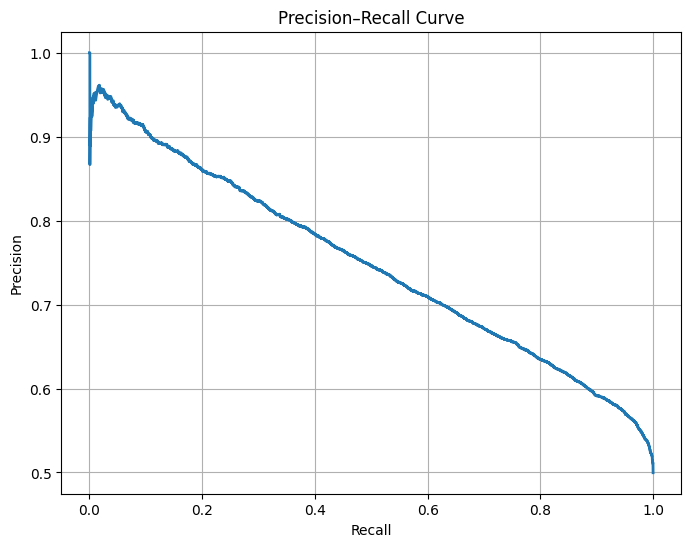

In [30]:
precision_xgb, recall_xgb, thresolds_xgb = precision_recall_curve(y_test,y_predict_xgb)
pr_auc_xgb = auc(recall_xgb,precision_xgb)
avg_precision_xgb = average_precision_score(y_test,y_predict_xgb)

print("PR-AUC:", pr_auc_xgb)
print("Average Precision Score:", avg_precision_xgb)

plt.figure(figsize=(8, 6))
plt.plot(recall_xgb, precision_xgb, linewidth=2)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve")
plt.grid(True)
plt.show()

In [31]:
print("Best PR-AUC Score:", gd.best_score_)
print("Best Params:", gd.best_params_)

Best PR-AUC Score: 0.7344073596130146
Best Params: {'model__learning_rate': 0.2, 'model__max_depth': 8, 'model__n_estimators': 150}


In [32]:
f1_scores = 2 * (precision_xgb * recall_xgb) / (precision_xgb + recall_xgb)
best_idx = np.argmax(f1_scores)

best_threshold = thresolds_xgb[best_idx]
best_f1 = f1_scores[best_idx]

print("Best Threshold:", best_threshold)
print("Best F1 Score:", best_f1)

Best Threshold: 0.3513025
Best F1 Score: 0.7162206039241152


In [33]:
y_pred_best = (y_predict_xgb >= best_threshold).astype(int)

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_best))

print("\nClassification Report:")
print(classification_report(y_test, y_pred_best))


Confusion Matrix:
[[ 5805 10947]
 [ 1289 15441]]

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.35      0.49     16752
           1       0.59      0.92      0.72     16730

    accuracy                           0.63     33482
   macro avg       0.70      0.63      0.60     33482
weighted avg       0.70      0.63      0.60     33482



#### CatBoost Created By Harsh Patel

In [39]:
feature_engineer = Feature_Engineering()

pipeline_cat = Pipeline(steps=[
    ('feature_engineer', feature_engineer),
    ('preprocessor', preprocess),
    ('model', CatBoostClassifier(
        loss_function='Logloss',
        eval_metric='AUC',
        verbose=0,
        random_seed=42,
        class_weights=[1, 1.3]
    ))
])

In [41]:
grid_params_cat = {
    'model__iterations': [200, 400],
    'model__depth': [6, 8, 10],
    'model__learning_rate': [0.05, 0.1]
}

In [42]:
gd_cat = GridSearchCV(
    estimator=pipeline_cat,
    param_grid=grid_params_cat,
    scoring='average_precision',
    cv=5,
    n_jobs=-1,
    verbose=3
)


gd_cat.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


,estimator,Pipeline(step...C883721550>)])
,param_grid,"{'model__depth': [6, 8, ...], 'model__iterations': [200, 400], 'model__learning_rate': [0.05, 0.1]}"
,scoring,'average_precision'
,n_jobs,-1
,refit,True
,cv,5
,verbose,3
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('target', ...), ('bool', ...), ...]"


In [43]:
y_predict_cat = gd_cat.predict_proba(X_test)[:, 1]

precision_cat, recall_cat, thresholds_cat = precision_recall_curve(y_test, y_predict_cat)
pr_auc_cat = auc(recall_cat, precision_cat)
avg_precision_cat = average_precision_score(y_test, y_predict_cat)

print("CatBoost PR-AUC:", pr_auc_cat)
print("CatBoost Average Precision:", avg_precision_cat)

CatBoost PR-AUC: 0.7744614090087467
CatBoost Average Precision: 0.7744853081697747


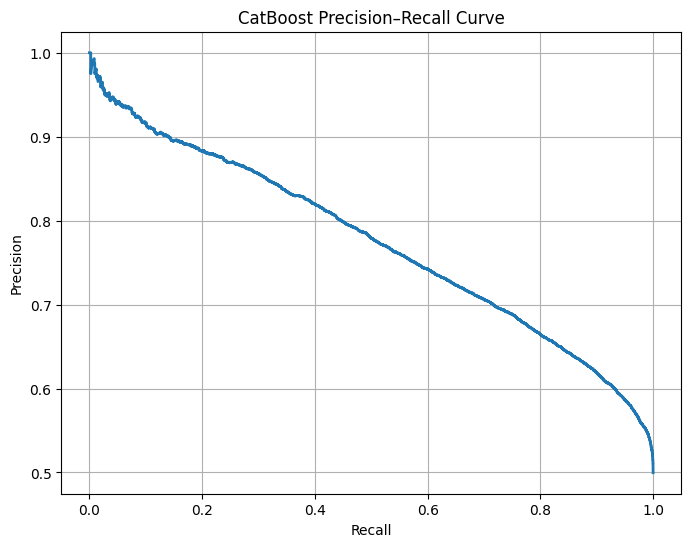

In [44]:
plt.figure(figsize=(8, 6))
plt.plot(recall_cat, precision_cat, linewidth=2)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("CatBoost Precision–Recall Curve")
plt.grid(True)
plt.show()

In [45]:
print("Best PR-AUC Score:", gd_cat.best_score_)
print("Best Params:", gd_cat.best_params_)

Best PR-AUC Score: 0.7621604064211768
Best Params: {'model__depth': 10, 'model__iterations': 400, 'model__learning_rate': 0.1}


In [46]:
f1_scores_cat = 2 * (precision_cat * recall_cat) / (precision_cat + recall_cat + 1e-9)
best_idx_cat = np.argmax(f1_scores_cat)

best_threshold_cat = thresholds_cat[best_idx_cat]
best_f1_cat = f1_scores_cat[best_idx_cat]

print("Best Threshold:", best_threshold_cat)
print("Best F1 Score:", best_f1_cat)

Best Threshold: 0.4489169066401495
Best F1 Score: 0.7343154369126963


In [47]:
y_pred_cat_best = (y_predict_cat >= best_threshold_cat).astype(int)

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_cat_best))

print("\nClassification Report:")
print(classification_report(y_test, y_pred_cat_best))


Confusion Matrix:
[[ 7750  9002]
 [ 1801 14929]]

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.46      0.59     16752
           1       0.62      0.89      0.73     16730

    accuracy                           0.68     33482
   macro avg       0.72      0.68      0.66     33482
weighted avg       0.72      0.68      0.66     33482

